## CSC420 Assignment 2
### Brendan Neal | 1001160236 | nealbre1

Imports and some helper functions

In [1]:
import numpy as np
import cv2 as cv
import math

from matplotlib import pyplot as plot

# Make the plot a certain size
plot.rcParams["figure.figsize"] = [8, 6]

# Shows an image, and saves it if a filename is given
def display_image(img, file_name=None):
    
    flt_img = img.astype(float)
    img_max, img_min = np.max(flt_img), np.min(flt_img)
    
    norm_img = (((flt_img - img_min) / (img_max - img_min)) * 255).astype(np.uint8)
    
    if len(img.shape) == 2:
        plot.imshow(norm_img, cmap='gray')
    elif (len(img.shape) == 3):
        plot.imshow(cv.cvtColor(norm_img, cv.COLOR_BGR2RGB))
    plot.show()
    
    if file_name:
        cv.imwrite(file_name, norm_img)

#### Question 1a: Harris/Brown Corner Metric Implementation

In [2]:
def derivative(float_img, kernel_size, x_degree, y_degree):
    return cv.Sobel(
        float_img, cv.CV_64F, 
        x_degree, y_degree, 
        ksize=kernel_size
    )

def gauss_blur(float_img, kernel_size, blur_width):
    return cv.GaussianBlur(
        float_img, (kernel_size, kernel_size), blur_width
    )

def corner_components(float_img):
    
    blurred = gauss_blur(float_img, 5, 7)
    i_x = derivative(blurred, 5, 1, 0)
    i_y = derivative(blurred, 5, 0, 1)
    
    i_x2 = gauss_blur(i_x ** 2, 7, 10)
    i_y2 = gauss_blur(i_y ** 2, 7, 10)
    i_xy = gauss_blur(i_x * i_y, 7, 10)
    
    det = (i_x2 * i_y2) - (i_xy ** 2)
    trace = i_x2 + i_y2
    
    return det, trace

def harris_corners(float_img, k):
    assert (0.04 <= k <= 0.06)
    
    det, trace = corner_components(float_img)
    return det - (k * (trace ** 2))

def brown_corners(float_img):
    det, trace = corner_components(float_img)
    
     # Dividing by 0 produces NAN, so ignore these pixels by setting them to 0 (0 = 0/1)
    det[trace == 0] = 0
    trace[trace == 0] = 1
    
    return det / trace



Applying the above code to *building.jpg*

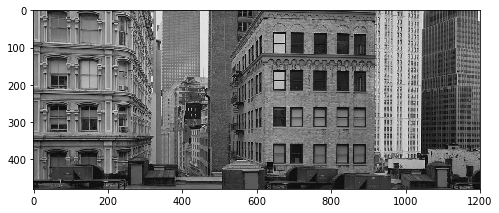

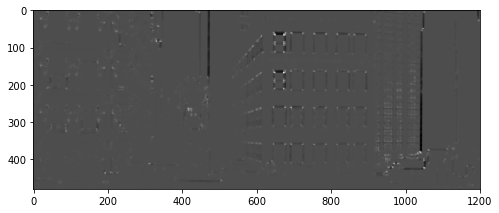

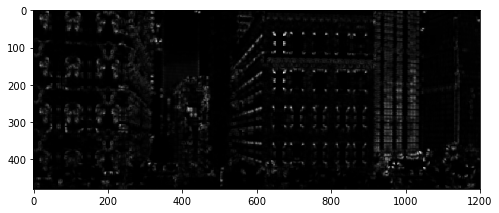

In [3]:
building = cv.imread("building.jpg", cv.IMREAD_GRAYSCALE).astype(np.float32)
display_image(building)

harris_building = harris_corners(building, 0.05)
display_image(harris_building, "q1A-harris-output.jpg")

brown_building = brown_corners(building)
display_image(brown_building, "q1A-brown-output.jpg")

The second and third images above are the Harris (R) and Brown (Harmonic Mean) corner metrics, respectively. 

They have been displayed in a normalized fashion (0 corresponds to original minimum pixel value, 255 to original maximum pixel value).

We can see that the Brown response metric produced an image with much higher variance than the Harris counterpart - the Brown response has many more black (minimum) and white (maximum) pixels. 

#### Question 1a: Non-Maximal Suppression

In [4]:
# Copied from A1
def patch_view(arr, patch_h, patch_w):
    """(numpy.array, int, int) -> numpy.array
    Creates a 4D, read-only view of some 2D numpy array as a 2D array of 2D patches.
    There are (arr_height x arr_width) patches and each patch is of size (patch_h, patch_w)

    :param arr: some 2D numpy array
    :param patch_h: desired height for patches
    :param patch_w: desired width for patches
    :return: 4D array of (patch_h x patch_w) patches
    """
    assert len(arr.shape) == 2

    # Numpy stride code examples (magic):
    # https://stackoverflow.com/questions/16774148/
    # https://github.com/keras-team/keras/issues/2983

    # New height and width are now going to be in terms of
    # number of overlapping patches we can fit into arr
    new_h, new_w = np.array(arr.shape) - np.array([patch_h, patch_w]) + 1

    return np.lib.stride_tricks.as_strided(
        np.ascontiguousarray(arr),
        shape=(new_h, new_w, patch_h, patch_w),
        strides=arr.strides + arr.strides,
        writeable=False
    )


def circular_mask(radius):
    """(int -> numpy.array)
    Creates a 2D-boolean mask of a circle with radius radius. 
    Returns a 2D, square array with side length size 2*radius + 1
    """
    
    diameter = 2*radius + 1
    
    center_x = center_y = radius
    x, y = np.indices((diameter, diameter))
    
    distances = ((center_x - x) ** 2 + (center_y - y) ** 2) ** 0.5
    return (distances <= radius)

def non_maximal_suppression(float_img, radius):
    
    # Radius should be odd 
    # (e.g. radius k -> patch of size (2k + 1)x(2k + 1))
    patch_size = (radius * 2) + 1
    
    # Pad the given image so the number of patches == number of pixels
    padding = patch_size // 2
    padded = np.pad(
        float_img, ((padding, padding), (padding, padding)),
        mode='constant', constant_values=0
    )
    
    # 2D Array of 2D patches
    patches = patch_view(padded, patch_size, patch_size)
    
    # Create circular mask for suppression in circular neighbourhood
    # (when taking maximum of patch, ignore pixels outside the mask)
    circle_mask = circular_mask(radius)
    patch_maxes = np.empty(float_img.shape)
    patch_maxes[:, :] = np.amax(patches[:, :] * circle_mask, axis=(2, 3))
    
    # Suppress pixels that are NOT the maximum within their patches
    ret = np.copy(float_img)
    ret[ret != patch_maxes] = 0
    
    return ret

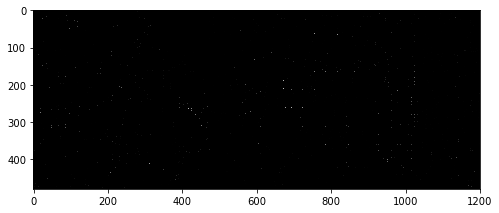

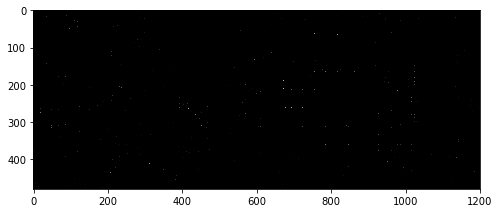

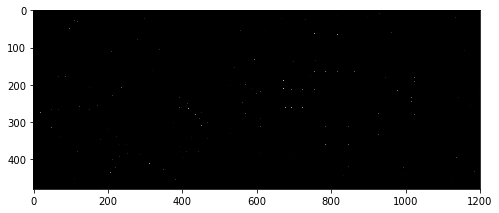

In [25]:
for radius in [2, 4, 8]:
    display_image(
        non_maximal_suppression(brown_building, radius), 
        f"q1B-nonmax-suppression-output-r={radius}.jpg"
    )

Note: Please see the raw image files attached in the submission. The PDF doesn't seem to treat isolated pixels very nicely.

We can see that as r increases, the amount of detected details decreases. This difference can be seen clearly between the 2 and 8-radius images. Particular areas of interest where fine details are displayed much more apparently are:

Building on the left-hand side, in particular the decorative window frames

Corners of the windows belonging to the distant tower on the right

Corners of the window-frames on the center building

The granularity of the high-response regions is inversely proportional to the radius of non-maximal suppression. This is because a larger radius causes the algorithm to inspect a wider neighbourhood. Therefore, the chance that the center pixel is a maximum is much lower, meaning that it has a higher chance of being suppressed. For pixels in the same neighbourhood, pixels that correspond to fine-details are more likely to be suppressed as they will have smaller response values.

#### Question 3: RANSAC

Recall: the minimum number of trials $S$ needed in order for RANSAC to produce a fitting model is

$$S(P, p, k) =\frac{log(1-P)}{log(1-p^k)}$$

Where:

$P$ is the probability that the trials produce a fitting model

$p$ is the proportion of inliers (number of inliers / number of points)

$k$ is the number of points used to fit the model

In [20]:
def S(P, p, k):
    return math.log(1 - P) / math.log(1 - (p ** k))

def show_scatter_plot(inputs, function, x_label, y_label):
    """
    Displays the scatter-plot of repeatedly applying function to the elements of inputs.
    X axis = input
    Y axis = function(input)
    """
    inps = list(inputs)
    
    plot.scatter(inps, [function(x) for x in inps])
    plot.xlabel(x_label)
    plot.ylabel(y_label)
    
    plot.show()

#### Question 3a: Plotting $k$ vs. $P(0.99, 0.7, k), k\in\{1...20\}$ 

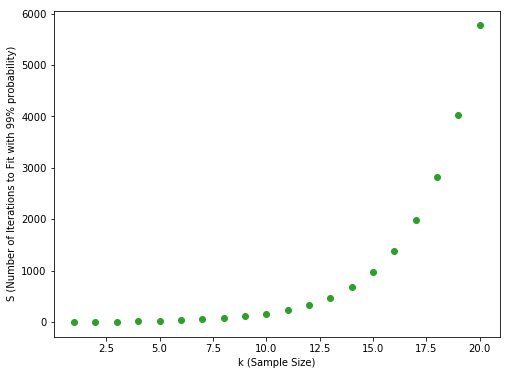

In [21]:
show_scatter_plot(
    range(1, 21), lambda k : S(0.99, 0.7, k), 
    "k (Sample Size)", 
    "S (Number of Iterations to Fit with 99% probability)"
)

#### Question 3a: Plotting $p$ vs. $P(0.99, p, 5), p\in[0.1, 0.5]$ 

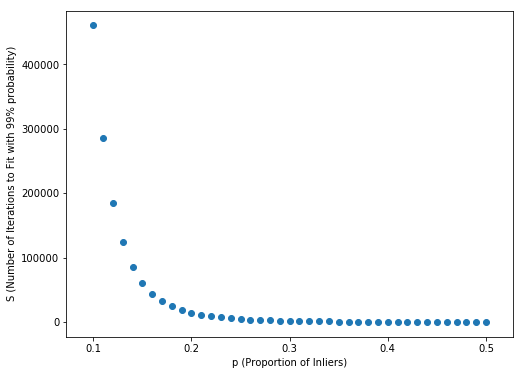

In [24]:
show_scatter_plot(
    (x / 100 for x in range(10, 51)), lambda p : S(0.99, p, 5),
    "p (Proportion of Inliers)", 
    "S (Number of Iterations to Fit with 99% probability)"
)

#### Question 3c: RANSAC Analysis

## TODO